In [4]:
import numpy as np
import xeshape
import blueice as bi
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
class DummyWaveformSource(xeshape.bi.WaveformSource):
    """Simple waveform source that makes Gaussian hits with a delta function PMT response
    """

    def simulate_wv_matrix(self, n_events):
        c = self.config
        hit_times = c['mean'] + c['sigma'] * np.random.randn(n_events * c['max_size'])
        hit_times -= self.ts[0]
        hit_indices = (hit_times // self.dt).astype(np.int)
        wv_matrix = xeshape.utils.split_groups(hit_indices, n_x=len(self.ts),
                                       distr=stats.randint(c['min_size'], c['max_size']))
        return wv_matrix

ts = np.arange(-100, 101, 10)

config = dict(
    sources=[dict(name='Freddie')],
    analysis_space=(('t', ts),),
    default_source_class=DummyWaveformSource,
    mean=0,  # Not very useful, since we'll be aligning!
    sigma=10,
    min_size=10,
    max_size=20,
    n_events_for_model=int(1e3),
    
    #delay_pdf_computation=True,
    # Temp for debugging
    # force_recalculation=True,
)

m = bi.Model(config, sigma=12, delay_pdf_computation=False)
plt.plot(ts, m.sources[0].waveform_model, linestyle='steps-mid')

In [6]:
ll = xeshape.bi.WaveformLikelihood(config)
sigma_anchors = np.arange(5, 26, 5)
ll.add_shape_parameter('sigma', sigma_anchors)
ll.prepare()
ll.set_data(m.sources[0].simulate_wv_matrix(int(1e4)))

Loading computed models: 100%|██████████| 5/5 [00:00<00:00, 1755.23it/s]


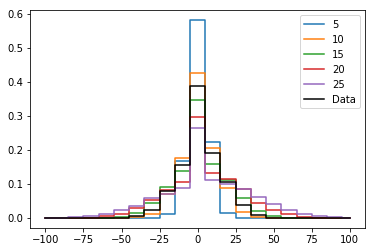

In [8]:
for q in sigma_anchors:
    plt.plot(ts, ll.anchor_models[(q,)].sources[0].waveform_model, label=q, linestyle='steps-mid')
plt.plot(ts, ll.data_waveform, c='k', linestyle='steps-mid', label='Data')
    #plt.errorbar(ts, ll.data_waveform, 
#             yerr=ll.errors * 10,
#             c='k', label='Data')
plt.legend()

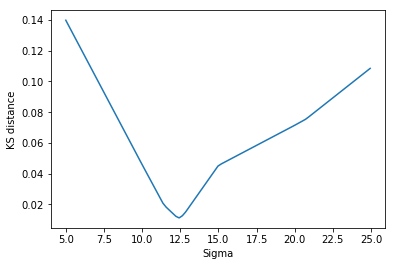

In [12]:
q = np.linspace(5, 26, 100)
plt.plot(q, [-ll(sigma=x) for x in q])
plt.xlabel("Sigma")
plt.ylabel("KS distance")

In [10]:
ll.bestfit_scipy()

(OrderedDict([('sigma', 12.36627197265625)]), -0.010809994635226916)

If you choose denser anchor points, fit will improve.